# Create and Destroy Device

__Device creation, vector operation and torch interop, destroying device__

Vulky is a python facade to vulkan with reduced and simpler interface focused primarly to academic purposes. Objects are designed to represent graphics pipelines and techniques in a more compact way.

In [1]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install pyav
    !pip install git+https://github.com/rendervous/vulky_project.git
except:
    print("Executing locally")

Executing locally


Let's start importing the module ```vulky```


In [2]:
import vulky as vk

Apart from rendering, vulky has objects to operate with vectors and matrices wrapping internally a torch tensor. This facilitates the interpretation of torch tensors as 3D objects and preserves differentiability when possible. This types also serves to declare equivalent vulkan shader types (```vec2```,...,```vec4```, ```mat2```, ..., ```mat4x3```, ```mat4```) 

In [3]:
a = vk.vec3(1., 0., .0)
b = vk.mat3.rotation(vk.vec3(0., 0.0, 1.0), 3.14159/2)
t = b@a
print(t)

vec3([1.2676e-06, 1.0000e+00, 0.0000e+00])


This vector and matrices types works also in batches. For instance, if you want to refer to a bidirectional array of (16,16) ```vec4``` you may use:

In [4]:
t = vk.vec4.zero(16, 16)
print(t)

vec4([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
   

Important observation is that indexing vectors and matrices refers to the component of the vector, not the instance of the batch, i.e.: 

In [5]:
t[0] = 1.0  # first component of all (16,16) vec4 where set to 1.0
t.y = 2.0  # equivalent to index, a named access to the field is also valid and refers to whole the batch
print(t)  

vec4([[[1., 2., 0., 0.],
         [1., 2., 0., 0.],
         [1., 2., 0., 0.],
         ...,
         [1., 2., 0., 0.],
         [1., 2., 0., 0.],
         [1., 2., 0., 0.]],

        [[1., 2., 0., 0.],
         [1., 2., 0., 0.],
         [1., 2., 0., 0.],
         ...,
         [1., 2., 0., 0.],
         [1., 2., 0., 0.],
         [1., 2., 0., 0.]],

        [[1., 2., 0., 0.],
         [1., 2., 0., 0.],
         [1., 2., 0., 0.],
         ...,
         [1., 2., 0., 0.],
         [1., 2., 0., 0.],
         [1., 2., 0., 0.]],

        ...,

        [[1., 2., 0., 0.],
         [1., 2., 0., 0.],
         [1., 2., 0., 0.],
         ...,
         [1., 2., 0., 0.],
         [1., 2., 0., 0.],
         [1., 2., 0., 0.]],

        [[1., 2., 0., 0.],
         [1., 2., 0., 0.],
         [1., 2., 0., 0.],
         ...,
         [1., 2., 0., 0.],
         [1., 2., 0., 0.],
         [1., 2., 0., 0.]],

        [[1., 2., 0., 0.],
         [1., 2., 0., 0.],
         [1., 2., 0., 0.],
         ...,
   

For graphics, internally, vulky works with one single vulkan instance at the time but might work with several devices. There is a concept of active device and most of the methods of vulky library refers implicitly to that device. The active device can be selected with the ```device_manager``` method passing the device object. By default, the creation of a device, makes that device the active one. Notice, it is not a problem not to save the device if there is no intention to switch between devices in a future.

In [6]:
vk.create_device(debug=True)

[INFO] Debug instance created...
[PRINT] Inserted device layer "VK_LAYER_KHRONOS_validation" (C:\VulkanSDK\1.3.275.0\Bin\.\VkLayer_khronos_validation.dll)
[PRINT] Inserted device layer "VK_LAYER_OBS_HOOK" (C:\ProgramData\obs-studio-hook\.\graphics-hook64.dll)
[PRINT] Inserted device layer "VK_LAYER_NV_optimus" (C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll)
[PRINT] vkCreateDevice layer callstack setup to:
[PRINT]    <Application>
[PRINT]      ||
[PRINT]    <Loader>
[PRINT]      ||
[PRINT]    VK_LAYER_NV_optimus
[PRINT]            Type: Implicit
[PRINT]                Disable Env Var:  DISABLE_LAYER_NV_OPTIMUS_1
[PRINT]            Manifest: C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\nv-vk64.json
[PRINT]            Library:  C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll
[PRINT]      ||
[PRINT]    VK_LAYER_OBS_HOOK
[PRINT]            Type: Implici

Vulky manages automatically two types of memory, the memory compatible with the host (CPU) and the memory purely in the graphic device (GPU). If cuda is present, the device memory is exported to cuda and Pytorch library, making the creation of tensors managed by vulkan simpler. 

In [7]:
t = vk.tensor(2,4)
print(t + 0.2)

tensor([[0.2000, 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000, 0.2000]], device='cuda:0')


Also, for the vector types the library provides different random generators based on torch.

In [8]:
a = vk.vec3.rand()  # U[0..1)
b = vk.vec3.randn()  # N(0, I)
c = vk.vec3.randd(1000)  # Uniform in hypersphere

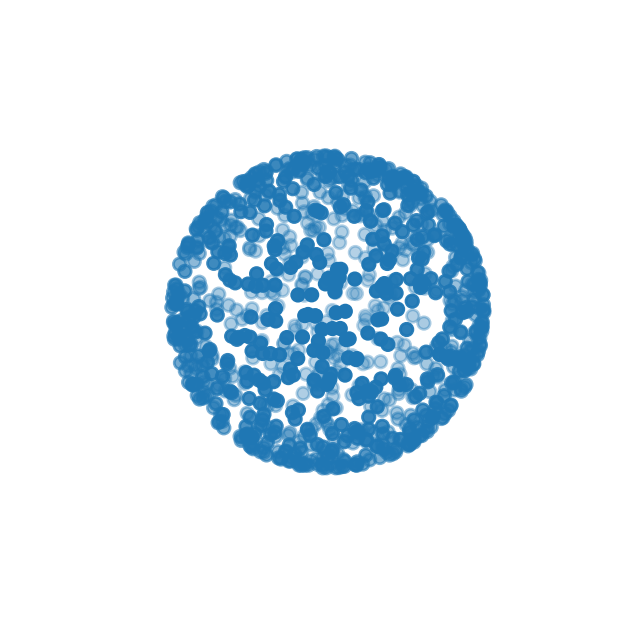

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(3,3), dpi=200)
ax = fig.add_subplot(projection='3d')
ax.scatter(c.x, c.y, c.z)
ax.axis('off')
ax.set_box_aspect((1,1,1))
fig.tight_layout(pad=0.0)
fig.savefig('teaser1.jpg')
plt.show()

Although vulky tensors can be operated as regular ```torch``` tensors, the memory is owned by vulky and they must be deleted before vulkan device is destroyed.

In [10]:
del t
vk.quit()

In the rest of the notebooks we won't close explicitly the device, although it is automatically performed at exit, it is unpleasant when we want to repeat cell executions and the device is already destroyed.